In [1]:
#setup & import
# Imports

import pandas as pd
import pickle
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score
)
import matplotlib.pyplot as plt
import joblib

In [9]:
# Define our cohort name (matching the folder in 'data/')
cohort = "mimic_cohort_NF_30_days"

In [10]:
#Loading cohort file

try:
    target = pd.read_csv(f"../data/{cohort}/{cohort}.csv.gz", compression="gzip", index_col=0) #main cohort data
    icd_codes_data = pd.read_csv(f"../data/{cohort}/{cohort}_icd_codes.csv.gz", compression="gzip", index_col=0)
    print("File loaded successfully.")
    icd_codes_data["icd_code_group"] = icd_codes_data["icd_code"].str[:3]  #selecting first 3 characters of ICD code
    # Bring in age and gender from the cohort
    icd_codes_data = icd_codes_data.merge(
        target[["hadm_id", "age", "gender"]],
        on=["subject_id", "hadm_id"],
        how="left")
    display(icd_codes_data)
except FileNotFoundError:
    print("\n FileNotFoundError: The file was not found at that path. please double check")
except Exception as e:
    print(e)

File loaded successfully.


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,icd_code_group,age,gender
0,10010231,21586397,1,Z5111,10,Encounter for antineoplastic chemotherapy,Z51,57,M
1,10010231,21586397,2,C9200,10,"Acute myeloblastic leukemia, not having achiev...",C92,57,M
2,10010231,23835132,1,Z5111,10,Encounter for antineoplastic chemotherapy,Z51,57,M
3,10010231,23835132,2,C92Z0,10,Other myeloid leukemia not having achieved rem...,C92,57,M
4,10010231,23835132,3,K760,10,"Fatty (change of) liver, not elsewhere classified",K76,57,M
...,...,...,...,...,...,...,...,...,...
79009,19999784,29956342,1,Z5111,10,Encounter for antineoplastic chemotherapy,Z51,57,M
79010,19999784,29956342,2,C8589,10,"Other specified types of non-Hodgkin lymphoma,...",C85,57,M
79011,19999784,29956342,3,E876,10,Hypokalemia,E87,57,M
79012,19999784,29956342,4,Z87891,10,Personal history of nicotine dependence,Z87,57,M


In [11]:
# Creating a binarized patient-feature matrix from the ICD codes

X_full = icd_codes_data.groupby(["hadm_id" , "icd_code"]).size().unstack("icd_code").fillna(0).astype("int")
X_full = (X_full > 0).astype(int)
X_full 

icd_code,A021,A047,A0471,A0472,A048,A072,A0811,A0839,A084,A088,...,Z9861,Z9862,Z98818,Z9882,Z9884,Z9889,Z98890,Z992,Z993,Z9981
hadm_id,,,,,,,,,,,,,,,,,,,,,
20000588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20004072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20004811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20006731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20008395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29987748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29987780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29990599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Load the 5-fold splits

with open(f'../data/{cohort}/cv_folds/fold_0.pkl', 'rb') as file:
    train_split, val_split, test_split = pickle.load(file)

fold_ids = []
for fold in range(5):
    with open(f'../data/{cohort}/cv_folds/fold_{fold}.pkl', 'rb') as f:
        train_split, val_split, test_split = pickle.load(f)
        train_split = np.concatenate([train_split, val_split])
        train_ids = train_split[:,1]  # hadm_id
        test_ids = test_split[:,1]
        fold_ids.append((train_ids, test_ids))
print("Folds loaded")

Folds loaded


In [13]:
# Train & evaluate XGBoost per fold

fold_metrics = []

all_y_test = []
all_y_pred = []
all_y_pred_proba = []


for fold_num, (train_ids, test_ids) in enumerate(fold_ids):
    X_train = X_full.loc[train_ids]
    X_test = X_full.loc[test_ids]

    y_train = target.set_index('hadm_id').loc[train_ids]['label']
    y_test = target.set_index('hadm_id').loc[test_ids]['label']

    # Handling Imbalance
    # Calculate the ratio for scale_pos_weight
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    model = XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42,
            eval_metric="logloss", n_jobs=-1,scale_pos_weight=scale_pos_weight
            )
    #Train
    model.fit(X_train, y_train)

    #Evaluate
    print("Evaluating Model...\n")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Store predictions for aggregate evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_proba.extend(y_pred_proba)
    
    # Metrics per fold 
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    fold_metrics.append({'fold': fold_num, 'AUC': auc, 'Accuracy': acc, 'F1': f1, 'Precision': prec, 'Recall': rec})
    print(f"Fold {fold_num} -> AUC: {auc:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

Evaluating Model...

Fold 0 -> AUC: 0.6788, Acc: 0.8818, F1: 0.1633, Prec: 0.1277, Recall: 0.2264
Evaluating Model...

Fold 1 -> AUC: 0.6173, Acc: 0.9064, F1: 0.1186, Prec: 0.0946, Recall: 0.1591
Evaluating Model...

Fold 2 -> AUC: 0.7232, Acc: 0.9018, F1: 0.2609, Prec: 0.2143, Recall: 0.3333
Evaluating Model...

Fold 3 -> AUC: 0.7092, Acc: 0.8930, F1: 0.2162, Prec: 0.1739, Recall: 0.2857
Evaluating Model...

Fold 4 -> AUC: 0.6368, Acc: 0.9080, F1: 0.1880, Prec: 0.1618, Recall: 0.2245



Aggregate -> AUC: 0.6771, Acc: 0.8983, F1: 0.1916, Prec: 0.1553, Recall: 0.2500


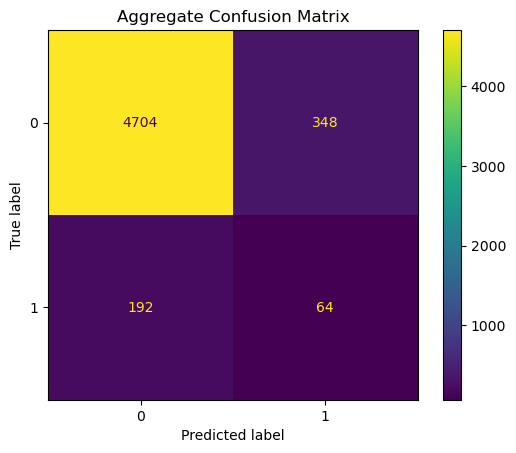

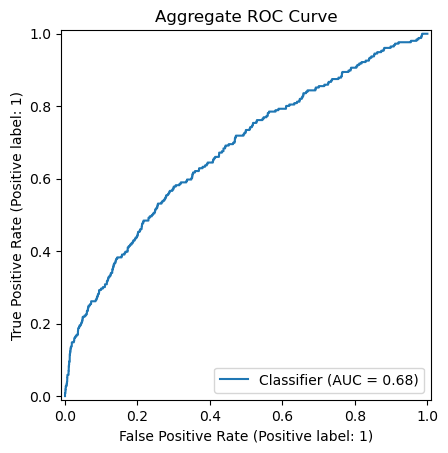

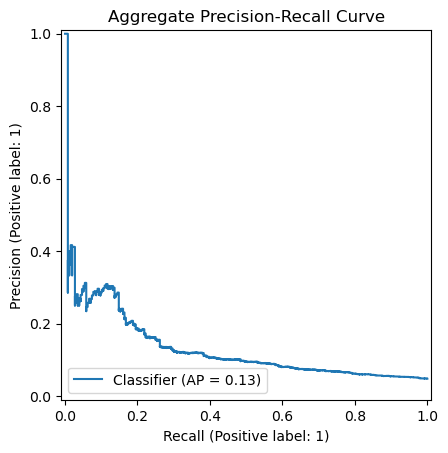

In [14]:
# ---------- Aggregate Metrics ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_y_pred_proba = np.array(all_y_pred_proba)

agg_auc = roc_auc_score(all_y_test, all_y_pred_proba)
agg_acc = accuracy_score(all_y_test, all_y_pred)
agg_f1 = f1_score(all_y_test, all_y_pred)
agg_prec = precision_score(all_y_test, all_y_pred)
agg_rec = recall_score(all_y_test, all_y_pred)

print(f"\nAggregate -> AUC: {agg_auc:.4f}, Acc: {agg_acc:.4f}, F1: {agg_f1:.4f}, Prec: {agg_prec:.4f}, Recall: {agg_rec:.4f}")

# ---------- Aggregate Plots ----------
cm = confusion_matrix(all_y_test, all_y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Aggregate Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(all_y_test, all_y_pred_proba)
plt.title("Aggregate ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(all_y_test, all_y_pred_proba)
plt.title("Aggregate Precision-Recall Curve")
plt.show()

In [15]:

# Cross-validation summary (mean ± std)
# -------------------------------
auc_list = [m['AUC'] for m in fold_metrics]
acc_list = [m['Accuracy'] for m in fold_metrics]
f1_list = [m['F1'] for m in fold_metrics]
prec_list = [m['Precision'] for m in fold_metrics]
rec_list = [m['Recall'] for m in fold_metrics]

print("\n=== CV Summary ===")
print(f"Mean AUC: {np.mean(auc_list):.4f} ± {np.std(auc_list):.4f}")
print(f"Mean Accuracy: {np.mean(acc_list):.4f} ± {np.std(acc_list):.4f}")
print(f"Mean F1: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
print(f"Mean Precision: {np.mean(prec_list):.4f} ± {np.std(prec_list):.4f}")
print(f"Mean Recall: {np.mean(rec_list):.4f} ± {np.std(rec_list):.4f}")

# ---------- Summary Table ----------
display(pd.DataFrame(fold_metrics))


=== CV Summary ===
Mean AUC: 0.6730 ± 0.0407
Mean Accuracy: 0.8982 ± 0.0097
Mean F1: 0.1894 ± 0.0480
Mean Precision: 0.1544 ± 0.0408
Mean Recall: 0.2458 ± 0.0593


,fold,AUC,Accuracy,F1,Precision,Recall
0,0,0.678816,0.881844,0.163265,0.127660,0.226415
1,1,0.617289,0.906391,0.118644,0.094595,0.159091
2,2,0.723181,0.901829,0.260870,0.214286,0.333333
3,3,0.709179,0.892989,0.216216,0.173913,0.285714
4,4,0.636780,0.908035,0.188034,0.161765,0.224490


In [16]:
# Training final model on full dataset

y_full = target.set_index('hadm_id').loc[X_full.index]['label']

final_model = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="logloss"
)
final_model.fit(X_full, y_full)

# Save the model
joblib.dump(final_model, f"../models/{cohort}_icd_codes_xgb_model.pkl")
print(f"Final model trained on full dataset and saved at ../models/{cohort}_icd_codes_xgb_model.pkl")

Final model trained on full dataset and saved at ../models/mimic_cohort_NF_30_days_icd_codes_xgb_model.pkl
